In [15]:
#Import 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from pyswarm import pso  # PSO
import joblib 

In [ ]:
csv_path = '../data/feature/feature.csv'
merged_df = pd.read_csv(csv_path)

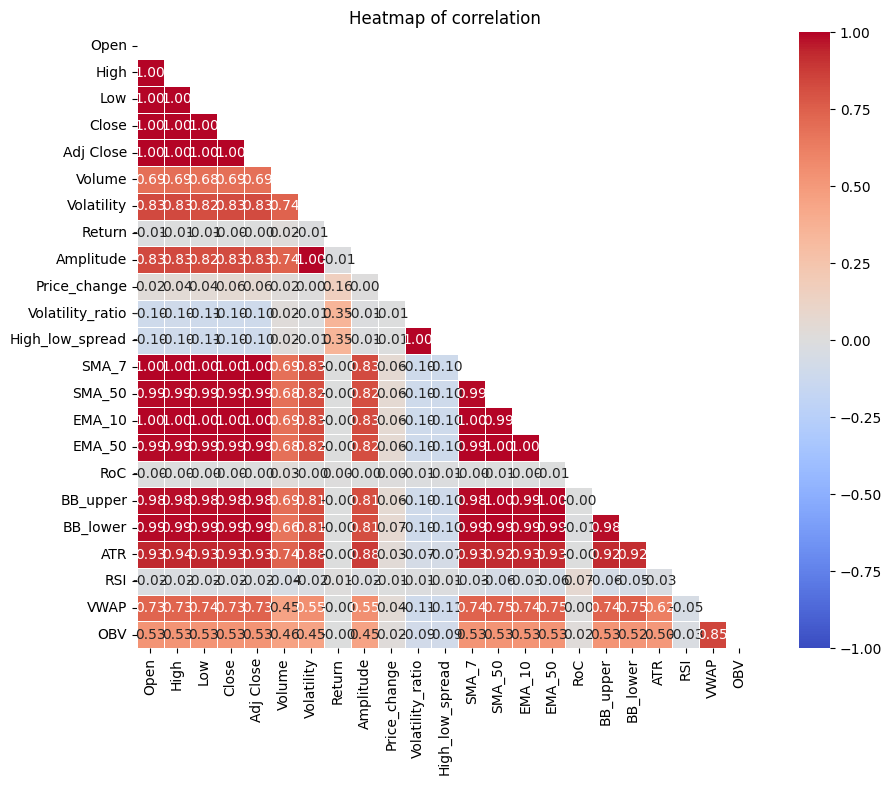

In [12]:
#Heatmap

corr_matrix = merged_df.drop(columns=['Date', 'Crypto']).corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', 
    linewidths=0.5, vmax=1, vmin=-1, square=True
)
plt.title("Heatmap of correlation")
plt.show()


C:\Users\33615\AppData\Local\Temp\ipykernel_832\987046026.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_return.index, y=corr_with_return.values, palette="coolwarm")


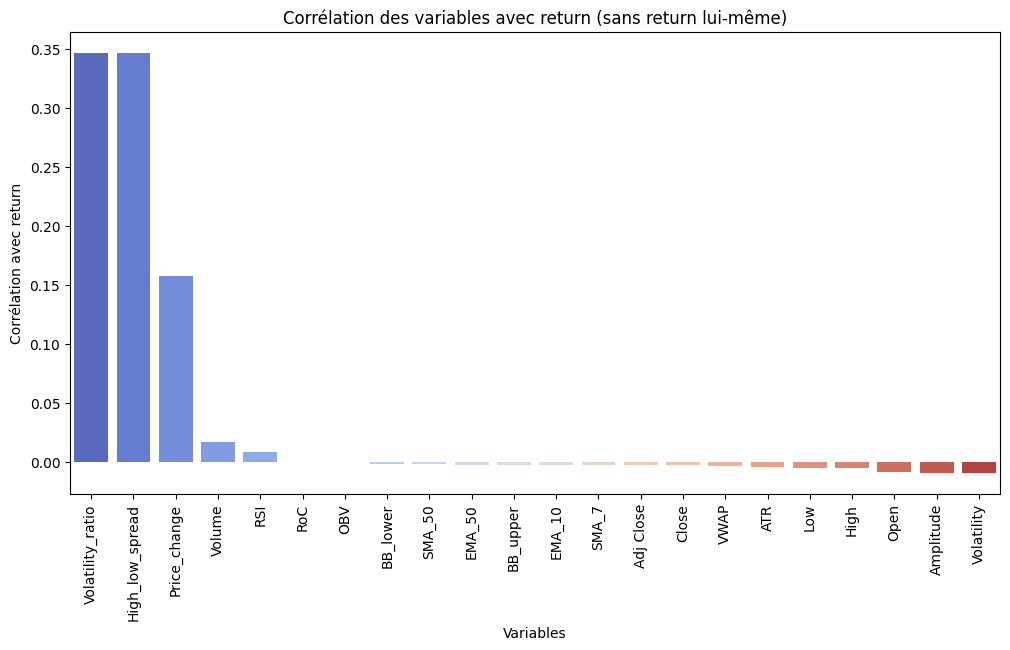

In [ ]:
# Correlation with target
corr_with_return = merged_df.drop(columns=['Date', 'Crypto']).corr()['Return'].drop('Return').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=corr_with_return.index, y=corr_with_return.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with return")
plt.title("Correlation of features with return")
plt.show()


In [9]:
# Modelisation with RandomForestRegressor

df = merged_df.copy()

features = ['Open', 'Volume', 'Volatility', 'Amplitude', 'Price_change', 'Volatility_ratio',
            'High_low_spread', 'RoC', 'ATR', 'RSI', 'VWAP', 'OBV']

target_rendement = 'Return'

X = df[features].values
y = df[target_rendement].values  

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
rf_rmse_scores = []
rf_r2_scores = []
rf_mae_scores = []
rf_explained_var_scores = []

# Cross-Validation
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    
    rf_model.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    rf_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_rf)))
    rf_r2_scores.append(r2_score(y_test, y_pred_rf))
    rf_mae_scores.append(mean_absolute_error(y_test, y_pred_rf))
    rf_explained_var_scores.append(explained_variance_score(y_test, y_pred_rf))

In [10]:
#PSO

def evaluate_rf(hyperparams):
    """
    Fonction d'évaluation du modèle Random Forest pour l'optimisation PSO.
    """
    n_estimators, max_depth = int(hyperparams[0]), int(hyperparams[1])

    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)

# Upper, Lower
lb = [50, 5]   
ub = [300, 30]

best_hyperparams, _ = pso(evaluate_rf, lb, ub, swarmsize=10, maxiter=5)

n_estimators_opt, max_depth_opt = int(best_hyperparams[0]), int(best_hyperparams[1])

print("Meilleurs hyperparamètres Random Forest trouvés par PSO:")
print(f"   - n_estimators: {n_estimators_opt}")
print(f"   - max_depth: {max_depth_opt}")

Stopping search: maximum iterations reached --> 5
Meilleurs hyperparamètres Random Forest trouvés par PSO:
   - n_estimators: 50
   - max_depth: 24


In [13]:
# Retraining with best params

optimized_rf = RandomForestRegressor(n_estimators=n_estimators_opt, max_depth=max_depth_opt, random_state=42, n_jobs=-1)

optimized_rf.fit(X_train, y_train)

y_train_pred = optimized_rf.predict(X_train)
y_test_pred = optimized_rf.predict(X_test)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    explained_var = explained_variance_score(y_true, y_pred)

    return mse, rmse, mae, r2, explained_var

# Metrics of Classification
mse_train, rmse_train, mae_train, r2_train, explained_var_train = evaluate_model(y_train, y_train_pred)
mse_test, rmse_test, mae_test, r2_test, explained_var_test = evaluate_model(y_test, y_test_pred)

print("\nScores du Random Forest optimisé :")
print(f"MSE : {mse_test:.6f}")
print(f"RMSE : {rmse_test:.6f}")
print(f"MAE : {mae_test:.6f}")
print(f"R² Score : {r2_test:.6f}")
print(f"Explained Variance : {explained_var_test:.6f}")


Scores du Random Forest optimisé :
MSE : 0.133857
RMSE : 0.365864
MAE : 0.166266
R² Score : 0.873480
Explained Variance : 0.873847


In [16]:
#Save model

model_filename = 'return_model.pkl'
joblib.dump(optimized_rf, model_filename)

print(f"Model saved under {model_filename}")


Model saved under return_model.pkl
